In [1]:
import heapq
import random
import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from numpy import array
from functools import reduce


class Event:
    '''
    Events are entities with timestamps. Processing logic is abstracted
    out to the Simulation class. 
    '''

    def __init__(self, timestamp, function) -> None:
        self.timestamp = timestamp
        self.function = function

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp


class Schedule:
    '''
    Implement an event schedule using a priority queue.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0
        self.queue = [] # The priority queue of events to run

    def add_event_at(self, timestamp, function):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(self.queue, Event(timestamp, function))

    def add_event_after(self, interval, function):
        # Add an event to the schedule after a specified time interval.
        heapq.heappush(self.queue, Event(self.now + interval, function))
    
    def next_event_time(self):
        # Min heaped so first entry is minimum of timestamp = earliest
        return self.queue[0].timestamp
    
    def get_next_event(self):
        next_event = heapq.heappop(self.queue)
        return next_event.timestamp, next_event.function

    def print_events(self):
        for event in sorted(self.queue):
            print(f'   {event.timestamp}: {event.function}')


In [2]:
class Passenger:
    def __init__(self, arrival_time, source, total_stops = 7) -> None:
        self.arrival_time = arrival_time
        self.source_stop = source
        self.destination_stop = (self.source_stop + random.randint(0,8))%total_stops + 1

        self.departure_time = None

    def __lt__(self, other):
        return self.arrival_time < other.arrival_time

    def print_attrs(self):
        print(f'source is {self.source_stop} dest is {self.destination_stop}')

    def annoyed(self, curr_time):
        wait_time = curr_time - self.arrival_time
        return wait_time > 10
    
class BusStop:
    def __init__(self, stop_index, lambda_ = 1) -> None:
        # Customers waiting for bus
        self.stop_queue = []
        self.stop_index  = stop_index
        self.lambda_ = lambda_
        self.arrival_distribution = lambda: sts.expon.rvs(scale = 1/self.lambda_)

    def customer_arrival(self, schedule, curr_time, n_stops = 7):
        # First come first served : either heap or sort before entering
        heapq.heappush(self.stop_queue, Passenger(arrival_time = curr_time, source = self.stop_index, total_stops = n_stops))
        # Schedule next customer arrival
        schedule.add_event_after(self.arrival_distribution(), self)

        return len(self.stop_queue)

    def get_annoyed_and_leave(self, curr_time): 
        # Check from the 21st passenger onwards
        annoyed_passengers = []

        if len(self.stop_queue) > 20:
            sorted_passengers = sorted(self.stop_queue)
            possibly_annoyed = sorted_passengers[21:]

            for passenger in possibly_annoyed:
                if passenger.annoyed(curr_time):
                    annoyed_passengers.append((curr_time - passenger.arrival_time))
                    self.stop_queue.remove(passenger)

            if len(annoyed_passengers):
                return annoyed_passengers 


class Bus:
    def __init__(self, location, last_stop) -> None:
        # Index of the stop the bus is currently at
        self.location = location

        self._name = location
        self._capacity = 130
        self._transit_time  = lambda: sts.truncnorm.rvs(a = 0, b = 10, loc = 2, scale = 0.5)
        self._boarding_time = lambda n: sts.truncnorm.rvs(a = 0,b = 10, loc = 0.05*n, scale = 0.01*(n**0.5))
        self._disembark_time = lambda n: sts.truncnorm.rvs(a = 0,b = 10, loc = 0.03*n, scale = 0.01*(n**0.5))
        self._last_stop = last_stop
        self.full = False

        # Passengers currently in bus
        self.passengers  = []

    def move_to_next_stop(self, schedule, delay):
        # Update position, loop if needed
        if self.location < self._last_stop:
            self.location += 1
        else: 
            self.location = 1

        # Schedule next stop
        travel_time = self._transit_time()
        schedule.add_event_after(travel_time + delay, self)

    def unload_passengers(self, bus_stop):
        # Identify passengers who need to get off
        departing_passengers = list(filter(lambda p: p.destination_stop == bus_stop.stop_index, self.passengers))
        unload_time = self._disembark_time(len(departing_passengers))

        for passenger in departing_passengers:
            self.passengers.remove(passenger)

        # Report unload time, departed Passengers for data collecting
        return unload_time, departing_passengers
    
    def load_passengers(self, curr_time, bus_stop):
        max_to_board  = self._capacity - len(self.passengers)

        n_to_board = min(len(bus_stop.stop_queue), max_to_board)
        time_to_load = self._boarding_time(n_to_board)

        # Load passengers on a first come, first served basis
        for p in range(n_to_board):
            # Exit the stop
            boarding_passenger = heapq.heappop(bus_stop.stop_queue)
            # Stamp the Passenger with departure time
            boarding_passenger.departure_time = curr_time
            # Add to bus
            self.passengers.append(boarding_passenger)

        return time_to_load


class Stats:
    def __init__(self, interval = 10) -> None:
        self.n_passengers = []
        self.max_queue = []
        self.interval = interval 

    def sample(self, schedule, curr_time, simulation):
        
        self.n_passengers.append((curr_time, [len(i.passengers) for i in simulation.buses]))

        self.max_queue.append((curr_time, simulation.max_queue_length))

        time_data = transpose_to_plot(self.n_passengers)
        y = [np.mean(time_data[1][i]) for i in range(len(time_data[1]))]

        # Steady state is avg of last 10 measurements
        simulation.steady_mean = np.mean(y[-10:])

        # Schedule next Stats sampling
        schedule.add_event_after(self.interval, self)



In [3]:
def transpose_to_plot(data):
    return list(zip(*data))

def mins_to_hours(times):
    t = array(times)
    return t//60 

In [4]:
class Simulation:
    def __init__(self, total_buses = 5, final_time = 24*60, lambda_ = 1, extended = False, pass_extended = False) -> None:
        
        # Parameters
        self.total_buses = total_buses
        self.total_stops = 15
        self.final_time  = final_time 

        self.extended = extended
        self.pass_extended = pass_extended

        # Simulation variables:
        self.served_passengers  = []
        self.max_queue_length = 0

        # Initialize simulation
        self.schedule  = Schedule()

        if self.extended:
            self.lambda_ = 1.2 + np.cos(np.pi*(self.schedule.now - 7)/6)
        else: 
            self.lambda_ = lambda_

        # Instantiate BusStops and load onto event schedule
        self.bus_stops = [BusStop(i + 1, lambda_ = self.lambda_) for i in range(self.total_stops)]
        for stop in self.bus_stops:
            self.schedule.add_event_at(0, stop)

        # Create a bus at each starting index. Bus_n <= BusStop_n
        self.buses = [Bus(location = i + 1, last_stop = self.total_stops) for i in range(self.total_buses)]
        for bus in self.buses:
            self.schedule.add_event_at(0, bus)

        # Initialize Stats data collector
        self.stats = Stats()
        self.schedule.add_event_at(0, self.stats)
        self.bus_times = []
        self.arrival_times = []
        self.annoyed = []
        self.steady_mean = 0

    def run(self):
        while self.schedule.now < self.final_time: 
            # Take the next event
            curr_time, function = self.schedule.get_next_event()
            # Update schedule to current time
            self.schedule.now = curr_time

            if isinstance(function, BusStop):

                if self.extended:
                    # Update arrival rate
                    hour = mins_to_hours(curr_time)
                    lambda1 = 1.2 + np.cos(np.pi*(hour - 7)/6)
                    function.lambda_ = lambda1

                if self.pass_extended:
                    # Second extension: annoyed passengers leave
                    a_pass = function.get_annoyed_and_leave(curr_time)
                    if a_pass:
                        self.annoyed.append((curr_time,a_pass))

                # Let a customer arrive
                queue_length = function.customer_arrival(self.schedule, curr_time, self.total_stops)
                
                if function.stop_index == 1:
                    self.arrival_times.append(curr_time)                

                # Check the maximum queue length
                if self.max_queue_length < queue_length:
                    self.max_queue_length = queue_length

            elif isinstance(function, Bus):
                # Check where the bus is
                current_stop = self.bus_stops[function.location - 1]

                if function._capacity == len(function.passengers):
                    function.full = True
                else:
                    function.full = False

                # For plots
                if function._name == 1:
                    self.bus_times.append((curr_time, function.location, function.full))

                disembark_time, departed_customers = function.unload_passengers(current_stop)
                loading_time = function.load_passengers(curr_time, current_stop)
                delay = loading_time + disembark_time

                # Update sim variable
                self.served_passengers.append((curr_time, departed_customers, function._name, function.location))

                # Move Bus to next stop, with loading/unloading delay is complete
                function.move_to_next_stop(self.schedule, delay)

            elif isinstance(function, Stats):
                function.sample(self.schedule, curr_time, self)

    def cum_plot(self):
        # An overview/check plots
        for bus in range(1, self.total_buses + 1):
            bus_data = list(filter(lambda d: d[2] == bus, self.served_passengers))
            plot_data = list(zip(*bus_data))

            plot_data[1] = [len(plot_data[1][i]) for i in range(len(plot_data[1]))]

            x = plot_data[0]
            y = np.cumsum(plot_data[1])

            plt.plot(x, y, label = f'Bus {bus} Cumulative Departures')
            plt.legend()

    def wait_times(self):
        data = list(zip(*self.served_passengers))
        # Compute wait times
        wait_times = [[p.departure_time - p.arrival_time for p in el] for el in data[1]]
        # Flatten array
        wait_times = reduce(lambda x,y: x + y, wait_times)

        return np.mean(wait_times)


    def plots(self):
        data = transpose_to_plot(self.served_passengers)

        fig = plt.figure(figsize=(10,15))
        fig.suptitle(f"Plots for Simulation with {self.total_buses} Bus over {self.final_time} minutes")

        gs = fig.add_gridspec(5, 1)

        ax1 = fig.add_subplot(gs[0, :])
        ax2 = fig.add_subplot(gs[1, :])
        ax3 = fig.add_subplot(gs[2, :])
        ax4 = fig.add_subplot(gs[3, :])
        ax5 = fig.add_subplot(gs[4, :])

        # Plot interrarival times
        mean_inter = np.mean([i[0] for i in np.diff(self.bus_times, axis = 0)])
        ax2.hist([i[0] for i in np.diff(self.bus_times, axis = 0)], bins = 30)
        ax2.axvline(mean_inter , color = "red", linewidth = 1, \
                        linestyle = '--', label = f"Mean transit time = {round(mean_inter)} mins")
        ax2.set_xlabel("Interarrival Times for Bus 1")
        ax2.set_ylabel("Frequency")
        ax2.legend()
        
        # Compute, flatten and plot wait times
        wait_times = [[p.departure_time - p.arrival_time for p in el] for el in data[1]]
        wait_times = reduce(lambda x,y: x + y, wait_times)
        expected_val = np.mean(wait_times)

        ax3.hist(wait_times, bins = 50)
        ax3.axvline( expected_val, color = "red", linewidth = 1, \
                        linestyle = '--', label = f"Mean waiting time = {round(expected_val)} mins")
        ax3.set_xlabel(f"Passenger Waiting Times (mins) across {self.total_buses} Buses")
        ax3.legend(loc = "lower right")

        # Compute interarrivals at Stop 1
        inter_arrivals = np.diff(self.arrival_times)
        ax4.hist(sts.expon.rvs(scale = 1, size = len(inter_arrivals)),
                    alpha = 0.5, label = "Theoretical Distribution")
        ax4.hist(inter_arrivals, 
                    alpha = 0.5, label = f"Empirical Distribution")
        ax4.axvline(np.mean(inter_arrivals), color = "red", linestyle = "--", 
                       label = f"Empirical $\lambda  = {round(np.mean(inter_arrivals), 2)}$")
        ax4.legend(loc = "upper right")
        ax4.set_xlabel("Bus Stop 1 Interarrival Times")

        time_data = transpose_to_plot(self.stats.n_passengers)
    
        t = time_data[0]
        y = [np.mean(time_data[1][i]) for i in range(len(time_data[1]))]

        # Average last 10 measurements
        self.steady_mean = np.mean(y[-10: -1])

        ax5.axhline(130, label = "Max capacity = 130", color = "red", linestyle = "--")
        ax5.plot(t,y)
        ax5.scatter(t,y)
        ax5.set_xlabel("Time since Midnight (mins)")
        ax5.set_ylabel("Average Number of Passengers in a Bus")
        ax5.legend()

        # Plot initial events
        plot_data = transpose_to_plot(self.bus_times)
        # Sample times but truncate to first two hours
        bus_times = plot_data[0][:35]
        stop_arrivals = self.arrival_times[:150]

        # Color "red" if bus is full or not
        bus_cols = ["Red" if obs else "Blue" for obs in plot_data[2]][:35]
        stop_cols = ["Blue" for obs in stop_arrivals]
        cols = [bus_cols, stop_cols]

        events = [bus_times, stop_arrivals]
        ax1.eventplot(events, linelengths= 0.3, colors = cols)
        ax1.set_yticks([0,1])
        ax1.set_yticklabels(['Bus 1', 'Passenger Arrivals \n at Stop 1'])
        ax1.set_xlabel("Event Time since Midnight (mins)")

        return sts.kstest(inter_arrivals, sts.expon.cdf), wait_times, y

    def max_queue_plot(self):
        plot_data = transpose_to_plot(self.stats.max_queue)

        plt.plot(plot_data[0], plot_data[1])
        plt.xlabel("Time since Midnight (mins)")
        plt.ylabel("Longest queue length")
        plt.title("Maximum Queue Length across 15 Stops")

class BatchRunner:
    def __init__(self, total_buses = 5, run_count = 3) -> None:
        self.total_buses = total_buses
        self.run_count = run_count
        self.sim_data = None
        self.plot_data = lambda: transpose_to_plot(self.sim_data.items())

    def batch_run(self):
        buses = range(1, self.total_buses + 1)
        sim_data = {bus: {"avg_wait": 0, "max_queue":0, "avg_passengers": 0} for bus in buses}

        for n_bus in buses:
            mean_wait_times = []
            max_queues = []
            avg_passengers = []

            for sim_run in range(self.run_count):
                this_sim = Simulation(total_buses = n_bus, extended= True, pass_extended= True)

                this_sim.run()

                mean = this_sim.wait_times()
                mean_wait_times.append(mean)

                max_queue = this_sim.max_queue_length
                max_queues.append(max_queue)

                avg_pass = this_sim.steady_mean
                avg_passengers.append(avg_pass)

            m = np.mean(mean_wait_times)
            t = sts.sem(mean_wait_times)

            sim_data[n_bus]["avg_wait"] = (m, 1.96*t)

            m_max = np.mean(max_queues)
            t_max = sts.sem(max_queues)

            sim_data[n_bus]["max_queue"] = (m_max, 1.96*t_max)

            m_pass = np.mean(avg_passengers)
            t_pass = sts.sem(avg_passengers)

            sim_data[n_bus]["avg_passengers"] = (m_pass, 1.96*t_pass)
        
        self.sim_data = sim_data

        return self.sim_data

    def wait_times_plot(self):
        if self.sim_data is not None:
            plot_data = self.plot_data()

            x = plot_data[0]

            y = [i["avg_wait"][0] for i in plot_data[1]]
            err = [i["avg_wait"][1] for i in plot_data[1]]

            plt.plot(x,y, color = "gray")
            plt.errorbar(x, y, err, fmt= '.k')
            plt.title("Average Waiting Time and its 95% Confidence Intervals \n Given the Number of Buses")
            plt.xlabel("Number of Buses")
            plt.ylabel("Average Waiting Time (minutes)")
            plt.show()
            
            print("Number of Buses | Average Waiting Time")
            print("---------------------------------------")
            
            for i in range(len(x)): 
                print(x[i], "               |   ", y[i])
        else:
            print("Run the simulation")

    def max_queue_plot(self):
        plot_data = self.plot_data()

        x = plot_data[0]

        y = [i["max_queue"][0] for i in plot_data[1]]
        err = [i["max_queue"][1] for i in plot_data[1]]

        plt.plot(x, y, color = "gray")
        plt.errorbar(x, y, err, fmt= '.k')
        plt.title("Average Max Queue Length and its 95% Confidence Intervals \n Given the Number of Buses")
        plt.xlabel("Number of Buses")
        plt.ylabel("Average Max Queue Length (number of waiting passengers)")
        plt.show()
        
        print("Number of Buses | Average Max Length")
        print("---------------------------------------")
            
        for i in range(len(x)): 
            print(x[i], "               |   ", y[i])

    def mean_passengers_plot(self):
        # Mean passengers at end of the simulation
        plot_data = self.plot_data()

        x = plot_data[0]

        y = [i["avg_passengers"][0] for i in plot_data[1]]
        err = [i["avg_passengers"][1] for i in plot_data[1]]

        plt.plot(x,y, color = "gray")
        plt.errorbar(x, y, err, fmt= '.k')
        plt.title("Average Number of Passengers and its 95% Confidence Intervals \n Given the Number of Buses")
        plt.xlabel("Number of Buses")
        plt.ylabel("Average Number of Passengers in Buses in Steady State")
        plt.show()
        
        print("Number of Buses | Average Number of Passengers")
        print("---------------------------------------")
            
        for i in range(len(x)): 
            print(x[i], "               |   ", y[i])

In [5]:
np.random.seed(seed=123)

plt.style.use('seaborn-whitegrid')

# Use one bus only for all the 15 stops

In [6]:
sim = Simulation(total_buses= 1)
sim.run()

KstestResult(statistic=0.019105970983190695, pvalue=0.6829159423814288)


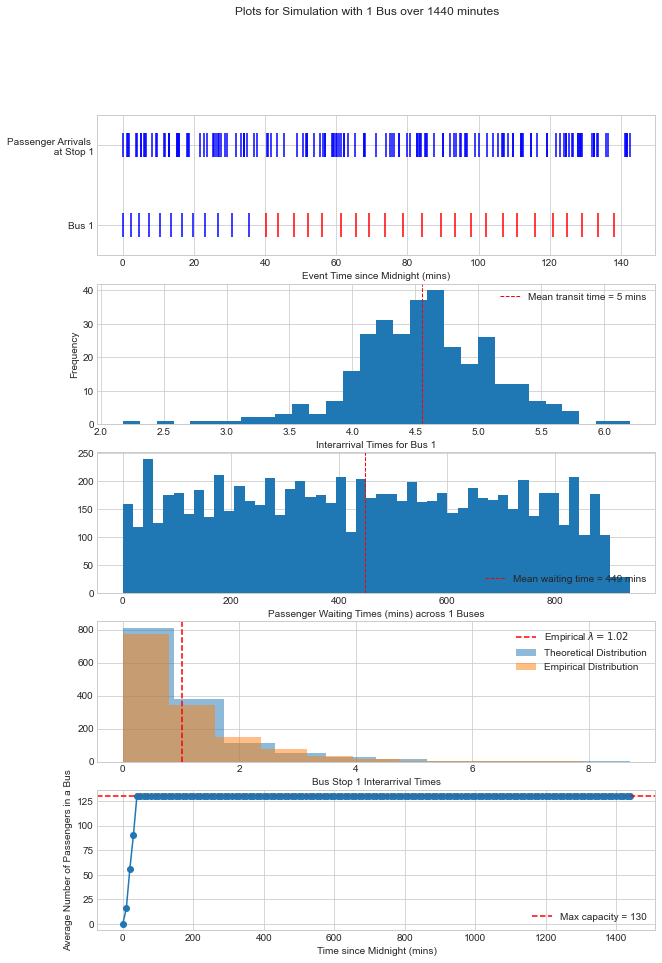

In [7]:
ks, wait, burden = sim.plots()
print(ks)

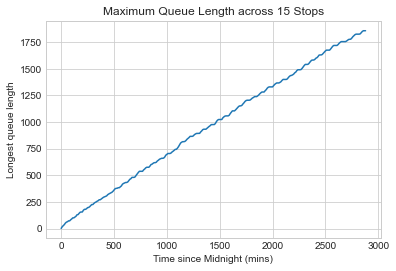

In [8]:
sim = Simulation(total_buses = 1, final_time = 48*60)
sim.run()
sim.max_queue_plot()

# Use 10 buses for all the 15 stops

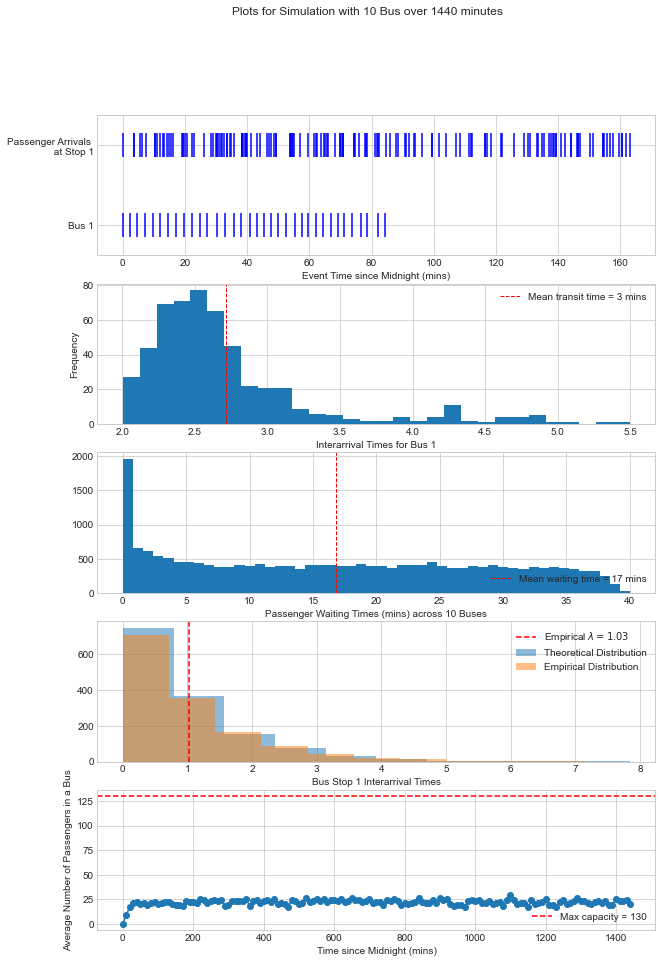

In [21]:
sim = Simulation(total_buses= 10)
sim.run()
ks, wait, burden = sim.plots()

# How many buses do we need?

In [15]:
batch = BatchRunner(total_buses=15, run_count = 30)

batch.batch_run()

{1: {'avg_wait': (48.669466894996525, 0.09850766504899695),
  'max_queue': (60.46666666666667, 0.41745692415494096),
  'avg_passengers': (129.12666666666667, 0.1797680173908267)},
 2: {'avg_wait': (28.235930394212797, 0.046101623388648025),
  'max_queue': (60.8, 0.5898744070494618),
  'avg_passengers': (84.11, 0.7835831075494044)},
 3: {'avg_wait': (24.011311428597836, 0.04558727456519339),
  'max_queue': (60.86666666666667, 0.9049599893782481),
  'avg_passengers': (56.65999999999999, 0.67069313537495)},
 4: {'avg_wait': (21.78166267794598, 0.04448030585687966),
  'max_queue': (60.266666666666666, 0.5787912361285),
  'avg_passengers': (42.95416666666667, 0.41744204934264456)},
 5: {'avg_wait': (20.378120740450083, 0.09032121517139713),
  'max_queue': (61.4, 0.6415114336784886),
  'avg_passengers': (34.392, 0.3265220903054973)},
 6: {'avg_wait': (19.255565392560143, 0.10047093551224287),
  'max_queue': (59.833333333333336, 0.6096302503531084),
  'avg_passengers': (29.274444444444445, 0.

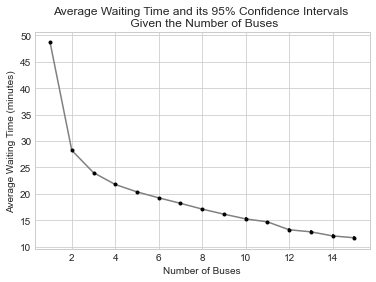

Number of Buses | Average Waiting Time
---------------------------------------
1                |    48.669466894996525
2                |    28.235930394212797
3                |    24.011311428597836
4                |    21.78166267794598
5                |    20.378120740450083
6                |    19.255565392560143
7                |    18.215530244519588
8                |    17.12327527730596
9                |    16.162539497520683
10                |    15.27645346734128
11                |    14.710945229087542
12                |    13.216350592618586
13                |    12.823383978793844
14                |    12.054537602468976
15                |    11.699255525077158


In [16]:
batch.wait_times_plot()

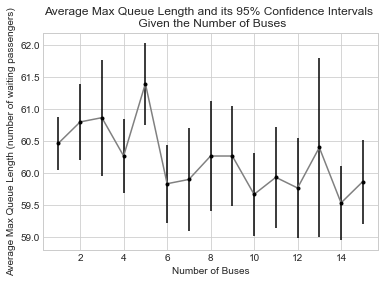

Number of Buses | Average Max Length
---------------------------------------
1                |    60.46666666666667
2                |    60.8
3                |    60.86666666666667
4                |    60.266666666666666
5                |    61.4
6                |    59.833333333333336
7                |    59.9
8                |    60.266666666666666
9                |    60.266666666666666
10                |    59.666666666666664
11                |    59.93333333333333
12                |    59.766666666666666
13                |    60.4
14                |    59.53333333333333
15                |    59.86666666666667


In [17]:
batch.max_queue_plot()

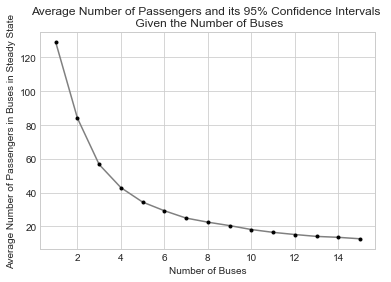

Number of Buses | Average Number of Passengers
---------------------------------------
1                |    129.12666666666667
2                |    84.11
3                |    56.65999999999999
4                |    42.95416666666667
5                |    34.392
6                |    29.274444444444445
7                |    24.923333333333332
8                |    22.50791666666667
9                |    20.474814814814813
10                |    18.154000000000003
11                |    16.483333333333334
12                |    15.203888888888889
13                |    14.082820512820515
14                |    13.540238095238095
15                |    12.671333333333335


In [18]:
batch.mean_passengers_plot()